In [104]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error,mean_squared_error
import plotly.express as px
from plotly import graph_objs as go
from prophet import Prophet

В рамках данного Notebook будет рассмотрено применение библиотеки *prophet* в задачах прогнозирования себсестоимости произвосдства товара и средней стоимости товара по конкурентам.

In [105]:
model_data = pd.read_csv("../all_data/itog/model_data_for_res.csv")
model_data.describe()

,price,amount,hot,rain,snow,cost,mean_of_comp_prices
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,11.788759,43.175000,0.175200,0.172600,0.167200,6.426621,11.348317
std,5.560588,10.799596,0.380151,0.377914,0.373167,3.660903,5.934720
min,2.730000,0.000000,0.000000,0.000000,0.000000,1.180000,0.000000
25%,7.690000,36.810184,0.000000,0.000000,0.000000,3.740000,7.247292
50%,10.530000,44.322832,0.000000,0.000000,0.000000,5.460000,10.840000
75%,14.820000,50.916591,0.000000,0.000000,0.000000,8.230000,14.820833
max,31.200000,70.696515,1.000000,1.000000,1.000000,24.520000,31.930000


In [106]:
cost_df = model_data[['place', 'product', 'date','cost']].copy()
price_con_df = model_data[['place', 'product','date','mean_of_comp_prices']].copy()

In [107]:
def vizualiz(data = 0,x = 'product', y ='place', target = 'cost'):
    for prod in data[x].unique():
        fig = go.Figure()
        for places in data[y].unique():
            linker = (data[y] == places) & (data[x] == prod)
                            
            fig.add_trace(go.Scatter(x=data[linker].date,
                                                    y=data.loc[linker][target], name = places))
            fig.update_layout(legend_orientation="h",
                                        title= prod )
        fig.show()

In [108]:
def link_taker(data = [], place = '', products = ''):
    linker = ((data["place"] == place) & (data["product"] == products))
    return data[linker]

______________________________________________

In [109]:
vizualiz(data = cost_df, x = 'product', y ='place',target = 'cost')
vizualiz(data = cost_df, y = 'product', x ='place',target = 'cost')

In [110]:
vizualiz(data = price_con_df[price_con_df['mean_of_comp_prices'] != 0], y = 'product', x ='place', target='mean_of_comp_prices')
vizualiz(data = price_con_df[price_con_df['mean_of_comp_prices'] != 0], x = 'product', y ='place', target='mean_of_comp_prices')

Исходя из приведенных выше графиков можно сказать:
1. Себестоимость производства товаров различна по каждому городу и продукту, то есть обобщить невозможно, требует отдельного исследования каждый случай(15 штук);
2. Средняя цена по конкурента также не имеет общей динамики ни по городу, ни по отдельным товарам, обобщение невозмонжо, поэтому будет исследоваться каждый товар и город по отдельности.


_________________________________________________________________

In [111]:
def analys(cost_intr_data,per):
    cost_intr_data.reset_index()
    cost_intr_data.columns = ['ds', 'y']
    model = Prophet()
    model.fit(cost_intr_data)
    period = model.make_future_dataframe(periods=per)
    prediction = model.predict(period)
    model.plot(prediction)
    model.plot_components(predictions)
    print("MAE_test", mean_absolute_error(predictions.yhat[-per:], 
                    cost_intr_data.y[-per:]))

    print("MSE_test", mean_squared_error(cost_intr_data.y[-per:], predictions.yhat[-per:]))


17:31:29 - cmdstanpy - INFO - Chain [1] start processing
17:31:29 - cmdstanpy - INFO - Chain [1] done processing
d:\Applications\Anaconda\envs\stan\lib\site-packages\prophet\plot.py:71: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

d:\Applications\Anaconda\envs\stan\lib\site-packages\prophet\plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

d:\Applications\Anaconda\envs\stan\lib\site-packages\prophet\plot.py:226: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarra

MAE_test 1.143559917943108
MSE_test 1.7221383971202315


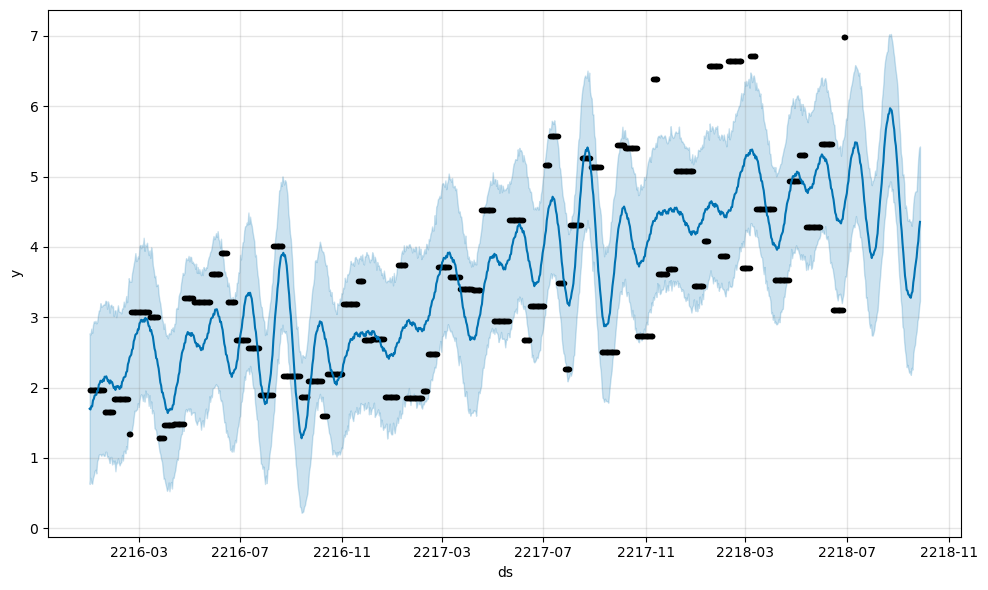

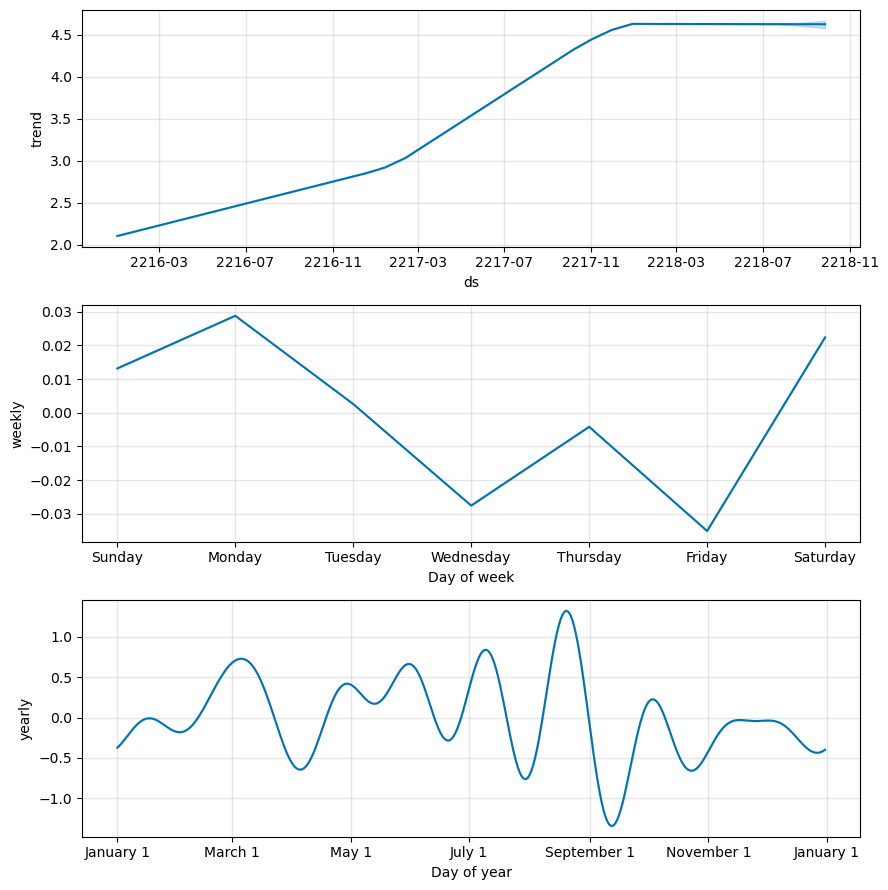

In [112]:
per = 90
cost_intr_data = link_taker(data =cost_df,
           place = 'Анор Лондо', 
           products= 'Эстус')[:-per][['date', 'cost']].copy()
analys(cost_intr_data,per)

В результаты нами были получены оценки качества моделм Prophet, как мы видим, показатели качества достаточно высоки, однако сложно судить о том насколько данный подход дает лучший результат по сравнению с использованным в кейсе. (Необходимы оценки по каждому городу, продукту)